In [251]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import itertools
from itertools import combinations
from scipy.stats import spearmanr


In [225]:
base_path = "somde_results"
A798015_rep1_nontumor = pd.read_csv(f"{base_path}/SN123_A798015_Rep1/somde_result.csv")
A798015_rep2_nontumor = pd.read_csv(f"{base_path}/SN124_A798015_Rep2/somde_result.csv")
A121573_rep1_tumor = pd.read_csv(f"{base_path}/SN048_A121573_Rep1/somde_result.csv")
A121573_rep2_tumor = pd.read_csv(f"{base_path}/SN048_A121573_Rep2/somde_result.csv")
A938797_rep1_tumor = pd.read_csv(f"{base_path}/SN123_A938797_Rep1_X/somde_result.csv")
A938797_rep2_tumor = pd.read_csv(f"{base_path}/SN124_A938797_Rep2/somde_result.csv")



Merge (or concat) the replicates of the same patient to get only three datasets totally. 

In [226]:
A798015_nontumor = pd.concat([A798015_rep1_nontumor, A798015_rep2_nontumor], ignore_index=True)
A121573_tumor = pd.concat([A121573_rep1_tumor, A121573_rep2_tumor], ignore_index=True)
A938797_tumor = pd.concat([A938797_rep1_tumor, A938797_rep2_tumor], ignore_index=True)

A798015_nontumor = A798015_nontumor[A798015_nontumor["qval"] < 0.05]
A121573_tumor = A121573_tumor[A121573_tumor["qval"] < 0.05]
A938797_tumor = A938797_tumor[A938797_tumor["qval"] < 0.05]


In [227]:
A121573_tumor = (
    A121573_tumor
    .groupby("g", as_index=False)["qval"]
    .min()
)

A938797_tumor = (
    A938797_tumor
    .groupby("g", as_index=False)["qval"]
    .min()
)

A798015_nontumor = (
    A798015_nontumor
    .groupby("g", as_index=False)["qval"]
    .min()
)


In [228]:
print(A938797_rep1_tumor.shape)
print(A938797_rep2_tumor.shape)
print(A938797_tumor.shape)

(36601, 19)
(36601, 19)
(20049, 2)


In [229]:
svg_t1 = set(A121573_tumor["g"])
svg_t2 = set(A938797_tumor["g"])
svg_nt = set(A798015_nontumor["g"])

In [230]:
tumor_shared = svg_t1.intersection(svg_t2)
tumor_all = svg_t1.union(svg_t2)
tumor_unique = tumor_all.difference(svg_nt)
nontumor_unique = svg_nt.difference(tumor_all)

In [231]:
tumor1_common = A121573_tumor[A121573_tumor["g"].isin(tumor_shared)].set_index("g")
tumor2_common = A938797_tumor[A938797_tumor["g"].isin(tumor_shared)].set_index("g")

In [ ]:
common_genes = tumor1_common.index.intersection(tumor2_common.index)
combined = pd.concat([tumor1_common.loc[common_genes], tumor2_common.loc[common_genes]])
combined_svg = combined.index
print(len(combined_svg))
combined_svg = pd.unique(combined_svg)
print(len(combined_svg))

combined_svg_sorted = sorted(combined_svg)

32350
16175


In [236]:
nontumor_common = A798015_nontumor[A798015_nontumor["g"].isin(combined_svg_sorted)].set_index("g")

In [235]:
# vyber qval pre spoločné gény
qvals1 = tumor1_common.loc[combined_svg_sorted, "qval"]
qvals2 = tumor2_common.loc[combined_svg_sorted, "qval"]


# vezmi minimum po génach
min_qvals = pd.Series(np.minimum(qvals1.values, qvals2.values), index=combined_svg_sorted)

In [242]:
common_genes_all = set(combined_svg_sorted).intersection(nontumor_common.index)
common_genes_all = sorted(common_genes_all)

scores_tumor_common = min_qvals.loc[common_genes_all].values
scores_nontumor_common = nontumor_common.loc[common_genes_all, "qval"].values

In [ ]:
# Spočítame Spearmanovu koreláciu
corr, pval = spearmanr(scores_tumor_common, scores_nontumor_common)
print("Spearman correlation between tumor and non-tumor qval:", corr)
print(f"p-value: {pval:.3e}")

Spearman correlation between tumor and non-tumor qval: 0.716327575176577
p-value: 0.0


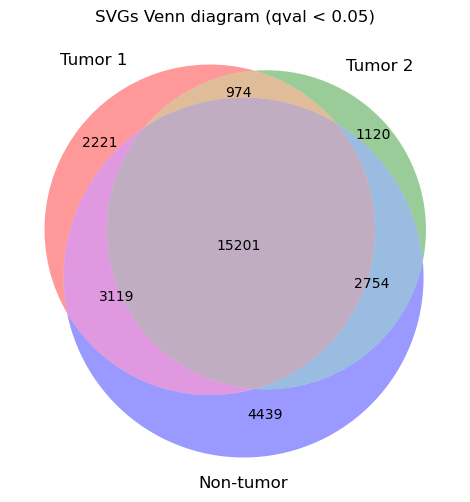

In [98]:
# -------------------------------
# Venn diagram
# -------------------------------
plt.figure(figsize=(6,6))
venn3([svg_t1, svg_t2, svg_nt], 
      set_labels=("Tumor 1", "Tumor 2", "Non-tumor"))
plt.title("SVGs Venn diagram (qval < 0.05)")
plt.show()

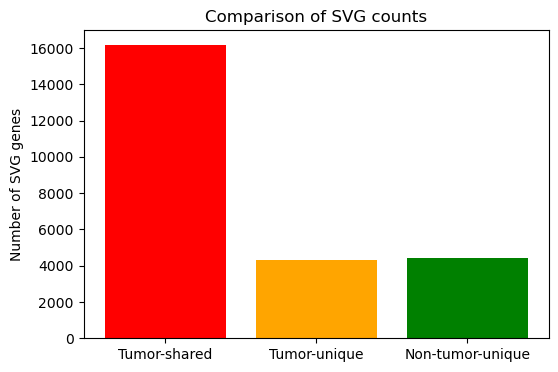

In [100]:
# -------------------------------
# Bar plot (counts)
# -------------------------------
counts = {
    "Tumor-shared": len(tumor_shared),
    "Tumor-unique": len(tumor_unique),
    "Non-tumor-unique": len(nontumor_unique)
}

plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color=["red", "orange", "green"])
plt.ylabel("Number of SVG genes")
plt.title("Comparison of SVG counts")
plt.show()